In [534]:
import numpy as np
import pandas as pd
from scipy import stats
path_to_file= r"vietnam_housing_dataset.csv"
vietnam_housing = pd.read_csv(r"vietnam_housing_dataset.csv")
vietnam_housing = vietnam_housing[['Address',	'Area',	'Frontage',	'Access Road',  'House direction',	'Balcony direction', 	'Floors',	'Bedrooms',	'Bathrooms',	'Legal status',	'Furniture state',	'Price']]

# TIỀN XỬ LÝ DỮ LIỆU

In [535]:
vietnam_housing.isna().any()

Address              False
Area                 False
Frontage              True
Access Road           True
House direction       True
Balcony direction     True
Floors                True
Bedrooms              True
Bathrooms             True
Legal status          True
Furniture state       True
Price                False
dtype: bool

In [536]:
vietnam_housing.dropna(inplace=True)

In [537]:
vietnam_housing.duplicated().any()

np.False_

In [538]:
vietnam_housing.drop_duplicates(inplace=True)

In [539]:
# Xử lí giá missing values
vietnam_housing['Frontage']  = vietnam_housing['Frontage'].fillna(vietnam_housing['Frontage'].median())
vietnam_housing['Access Road'] = vietnam_housing['Access Road'].fillna(vietnam_housing['Access Road'].median())
vietnam_housing['Floors']    = vietnam_housing['Floors'].fillna(vietnam_housing['Floors'].median())
vietnam_housing['Bedrooms']  = vietnam_housing['Bedrooms'].fillna(vietnam_housing['Bedrooms'].median())
vietnam_housing['Bathrooms'] = vietnam_housing['Bathrooms'].fillna(vietnam_housing['Bathrooms'].median())
for col in ['House direction', 'Balcony direction', 'Legal status', 'Furniture state']:
    vietnam_housing[col] = vietnam_housing[col].fillna('Unknown')


In [540]:
# Kiểm tra trùng lặp lần nữa
vietnam_housing.drop_duplicates(inplace=True)
vietnam_housing.describe()


,Area,Frontage,Access Road,Floors,Bedrooms,Bathrooms,Price
count,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000
mean,70.722979,5.480749,7.605142,3.209452,3.473346,3.355009,5.444760
std,50.359338,4.917664,7.571208,1.277935,1.182540,1.341140,2.240992
min,3.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,40.000000,4.000000,3.000000,2.000000,3.000000,2.000000,3.680000
50%,60.000000,4.500000,5.000000,3.000000,3.000000,3.000000,5.250000
75%,83.000000,5.000000,8.000000,4.000000,4.000000,4.000000,7.190000
max,501.000000,73.000000,85.000000,7.000000,9.000000,9.000000,10.900000


### Xử lí outliers

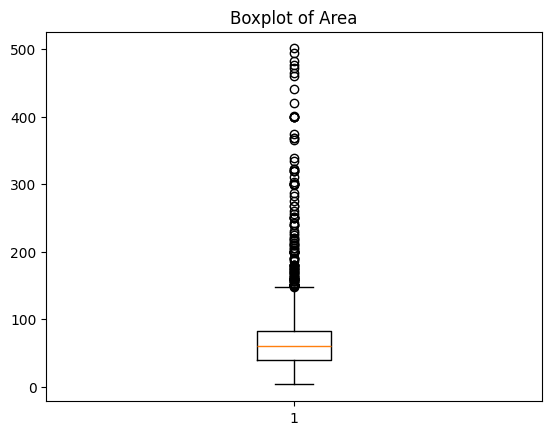

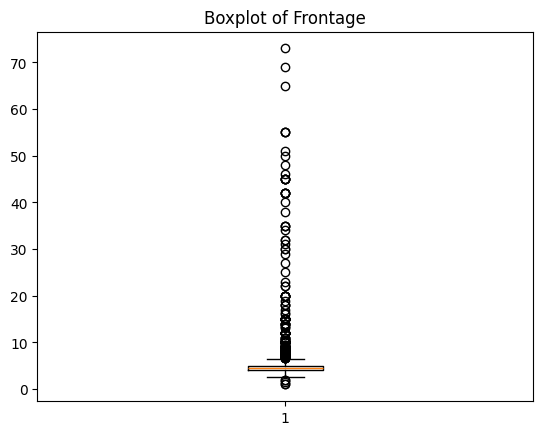

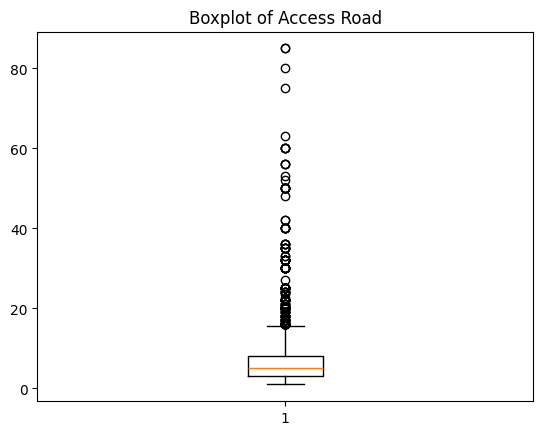

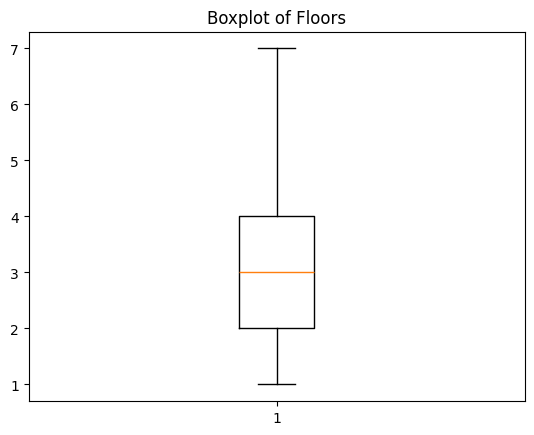

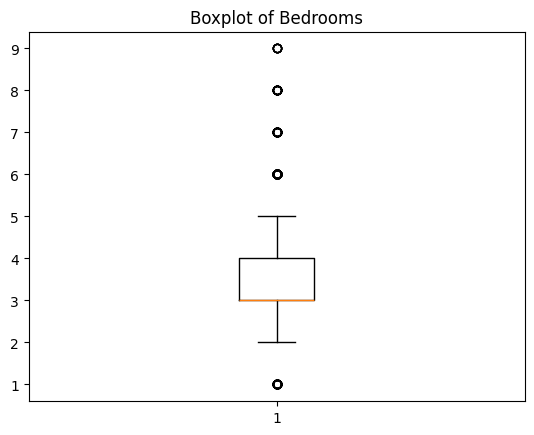

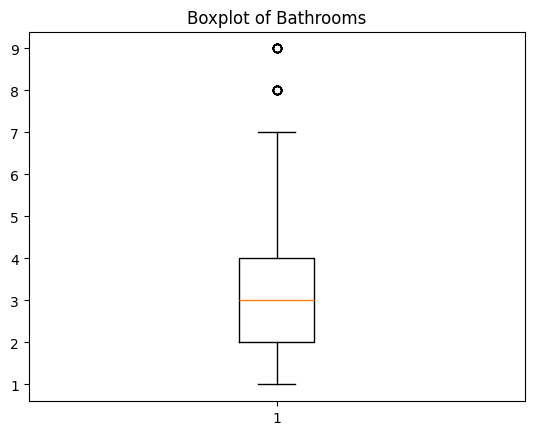

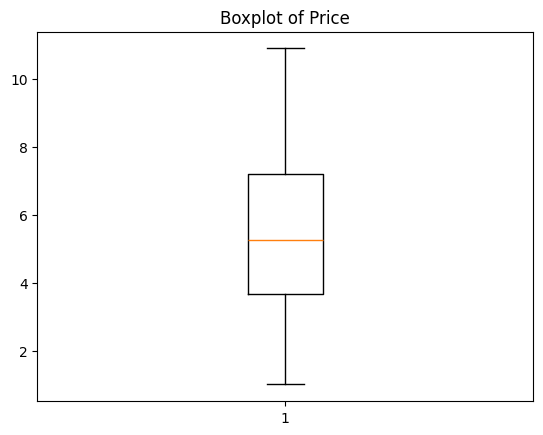

In [541]:
import matplotlib.pyplot as plt

cols = ['Area', 'Frontage', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms', 'Price']
for col in cols:
    plt.figure()
    plt.boxplot(vietnam_housing[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
vietnam_housing = vietnam_housing[(np.abs(stats.zscore(vietnam_housing[cols])) < 3).all(axis=1)]

In [542]:
import sklearn
from sklearn.datasets import load_diabetes
import pandas as pd
print("Old Shape: ", vietnam_housing.shape)
cols = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms','Price']
for col in cols:
    # Tính các giá trị phân vị
    Q1 = vietnam_housing[col].quantile(0.25)
    Q3 = vietnam_housing[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Tìm chỉ số các giá trị nằm ngoài giới hạn
    upper_array = np.where(vietnam_housing[col] > upper)[0]
    lower_array = np.where(vietnam_housing[col] < lower)[0]
 # Tạo mask xác định outliers
    mask = (vietnam_housing[col] < lower) | (vietnam_housing[col] > upper)
    n_outliers = mask.sum()
    # Giữ lại những dòng hợp lệ
    vietnam_housing = vietnam_housing.loc[~mask]
print("New Shape:", vietnam_housing.shape)

Old Shape:  (2499, 12)
New Shape: (1981, 12)


In [543]:
for col in ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']:
    Q1 = vietnam_housing[col].quantile(0.25)
    Q3 = vietnam_housing[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    mask = (vietnam_housing[col] < lower) | (vietnam_housing[col] > upper)
    print(f"{col}: {mask.sum()} outliers")


Area: 13 outliers
Frontage: 0 outliers
Access Road: 31 outliers
Bedrooms: 0 outliers
Bathrooms: 0 outliers
Price: 0 outliers


### Chuẩn hóa dữ liệu

In [544]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sao chép dữ liệu để không làm thay đổi bản gốc
vietnam_housing = pd.DataFrame(vietnam_housing)
vietnam_housing_clean = vietnam_housing.copy()
## --- Hàm mã hóa hướng theo sin-cos ---
def encode_direction(df, col):
    angle_map = {
        'Đông': 0, 'Đông Nam': 45, 'Nam': 90, 'Tây Nam': 135,
        'Tây': 180, 'Tây Bắc': 225, 'Bắc': 270, 'Đông Bắc': 315
    }
    angles = df[col].map(angle_map).fillna(0)
    df[col+'_sin'] = np.sin(np.deg2rad(angles))
    df[col+'_cos'] = np.cos(np.deg2rad(angles))
    return df

# --- Mã hóa hướng nhà & ban công ---
vietnam_housing_clean = encode_direction(vietnam_housing, 'House direction')
vietnam_housing_clean = encode_direction(vietnam_housing, 'Balcony direction')

# --- Mã hóa biến phân loại khác ---
for col in ['Legal status', 'Furniture state']:
    le = LabelEncoder()
    vietnam_housing_clean[col] = le.fit_transform(vietnam_housing[col].astype(str))


In [545]:
#  Chuẩn hóa dữ liệu số
cols_to_scale = ['Area', 'Frontage', 'Access Road','Bedrooms', 'Bathrooms', 'Price']
scaler = StandardScaler()

vietnam_housing_clean[cols_to_scale] = scaler.fit_transform(vietnam_housing_clean[cols_to_scale])

#  Kiểm tra kết quả
print(" Dữ liệu sau khi mã hóa & chuẩn hóa:")
print(vietnam_housing_clean[['Area', 'Frontage','Access Road', 'Bedrooms', 'Bathrooms', 'Price',
                             'Legal status', 'Furniture state',
                             'House direction_sin', 'House direction_cos',
                             'Balcony direction_sin', 'Balcony direction_cos']].head())

print(" Mean sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].mean().round(2))

print(" Std sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].std().round(2))

 Dữ liệu sau khi mã hóa & chuẩn hóa:
         Area  Frontage  Access Road  Bedrooms  Bathrooms     Price  \
19  -0.521553  0.281668     0.141511  0.855516    1.59219  1.305879   
61   0.426969 -0.511298    -0.346421 -0.369034    0.68791  2.247476   
111 -1.055353 -1.832909    -1.159640 -0.369034    0.68791 -0.338402   
112 -0.850045 -0.246976     0.141511 -0.369034    0.68791  0.739047   
142 -1.055353  0.149507    -0.996996 -0.369034    0.68791 -0.492993   

     Legal status  Furniture state  House direction_sin  House direction_cos  \
19              0                1                  0.0         1.000000e+00   
61              0                1                  0.0         1.000000e+00   
111             0                1                  0.0         1.000000e+00   
112             0                1                  0.0         1.000000e+00   
142             0                1                  1.0         6.123234e-17   

     Balcony direction_sin  Balcony direction_cos  
19 

In [546]:
# xóa các khoảng trắng thay đinh do bằng gạch dưới
vietnam_housing.columns = vietnam_housing.columns.str.replace(' ', '_')

### PHÂN CỤM DỮ LIỆU

In [547]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = vietnam_housing_clean[['Area','Access_Road','Frontage','Bedrooms','Bathrooms',
                     'Price','House_direction_sin','House_direction_cos',
                     'Balcony_direction_sin','Balcony_direction_cos',
                     'Legal_status','Furniture_state']].copy()

# Xử lý NaN cho cột số & phân loại
num_cols = ['Area','Access_Road','Frontage','Bedrooms','Bathrooms','Price',
            'House_direction_sin','House_direction_cos',
            'Balcony_direction_sin','Balcony_direction_cos']
cat_cols = ['Legal_status','Furniture_state']

X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])
X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])

# Scale dữ liệu số
X[num_cols] = StandardScaler().fit_transform(X[num_cols])


In [548]:
# Chạy KMeans
km_inertias, km_scores = [], []
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X, km.labels_))
    print(f"k={k} | Inertia={km.inertia_:.2f} | Silhouette={km_scores[-1]:.4f}")


k=3 | Inertia=13986.71 | Silhouette=0.1961


k=4 | Inertia=11956.25 | Silhouette=0.2188
k=5 | Inertia=10740.36 | Silhouette=0.2464
k=6 | Inertia=9534.97 | Silhouette=0.2351
k=7 | Inertia=8999.53 | Silhouette=0.2163
k=8 | Inertia=8602.59 | Silhouette=0.1944
k=9 | Inertia=8240.50 | Silhouette=0.1942


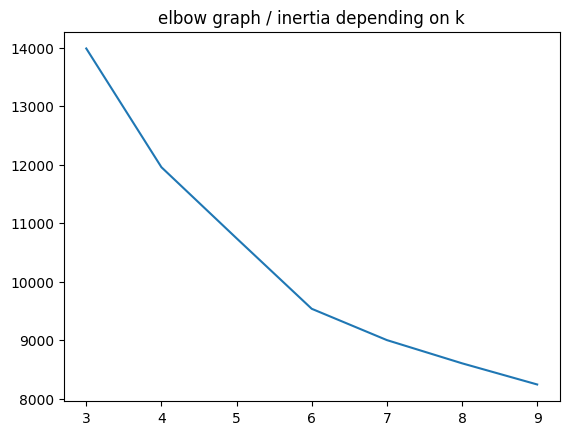

k = 3, Silhouette Score = 0.303
k = 4, Silhouette Score = 0.217
k = 5, Silhouette Score = 0.203
k = 6, Silhouette Score = 0.160
k = 7, Silhouette Score = 0.193
k = 8, Silhouette Score = 0.212
k = 9, Silhouette Score = 0.186


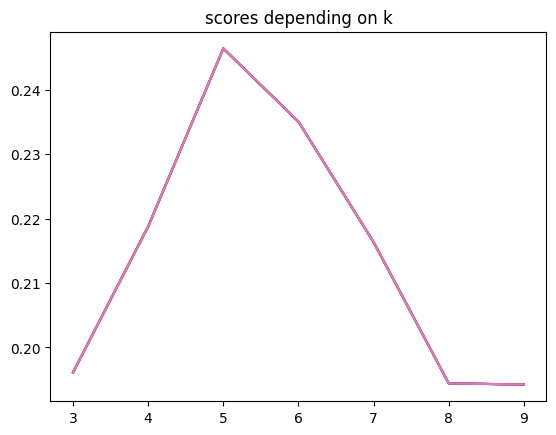

In [549]:
# sns.lineplot(range(3, 10), km_inertias) PHUOCNT
sns.lineplot(x=range(3, 10), y=km_inertias)
plt.title('elbow graph / inertia depending on k')
plt.show()
# Bổ sung kiểm tra bằng Silhouette Score
from sklearn.metrics import silhouette_score
for k in range(3, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    score = silhouette_score(X, km.labels_)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    sns.lineplot(x=range(3, 10), y=km_scores)
plt.title('scores depending on k')
plt.show()


In [550]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=4).fit(X)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(4):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')
 

Cluster nb : 0
       Access_Road    Frontage    Bedrooms   Bathrooms       Price  \
count   438.000000  438.000000  438.000000  438.000000  438.000000   
mean      0.171700    0.647343   -0.721302   -0.895612   -0.411751   
std       0.854458    0.859823    0.726354    0.592920    0.843511   
min      -1.159640   -1.832909   -1.593584   -2.024929   -1.968629   
25%      -0.509065    0.149507   -1.593584   -1.120649   -1.002439   
50%      -0.021133    0.810312   -0.369034   -1.120649   -0.563261   
75%       0.629442    0.810312   -0.369034   -0.216370    0.045732   
max       3.231744    2.792727    2.080067    0.687910    2.106939   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count           438.000000           438.000000             438.000000   
mean              0.324632             0.297014               0.312788   
std               0.870885             0.631205               0.837080   
min              -2.242919            -2.517002           

In [551]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=5).fit(X)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(5):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')

Cluster nb : 0
       Access_Road    Frontage    Bedrooms   Bathrooms       Price  \
count   216.000000  216.000000  216.000000  216.000000  216.000000   
mean      0.023745    0.007250   -0.034550    0.009700   -0.043297   
std       1.074054    0.957588    1.032616    0.983847    0.974163   
min      -1.224698   -2.361553   -1.593584   -2.024929   -1.757824   
25%      -0.834352   -0.511298   -0.369034   -1.120649   -0.750644   
50%      -0.183777   -0.246976   -0.369034   -0.216370   -0.153362   
75%       0.466799    0.810312    0.855516    0.687910    0.631302   
max       3.134158    2.792727    2.080067    3.400749    2.247476   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count           216.000000           216.000000             216.000000   
mean              2.146810            -0.975175               2.097774   
std               0.211689             0.149400               0.295198   
min              -0.037846            -2.517002           

In [552]:
print("KMeans n_clusters:", km.n_clusters)
print("Shape of X_scaled:", X.shape)
print("Unique cluster labels:", np.unique(X['Label']))
print("Number of duplicates:", vietnam_housing.duplicated().sum())


KMeans n_clusters: 5
Shape of X_scaled: (1981, 13)
Unique cluster labels: [0 1 2 3 4]
Number of duplicates: 0


In [553]:
import plotly.graph_objects as go

# Chọn 2 biến để vẽ (có thể đổi sang biến khác)
x_col = 'Price'
y_col = 'Bathrooms'
# Lấy dữ liệu cho 2 biến đó
x = X[x_col].values
y = X[y_col].values
fig = go.Figure()
# Vẽ từng cụm
for i, color in zip(range(km.n_clusters), ['#DB4CB2', '#c9e9f6', '#7D3AC1']):
    fig.add_trace(go.Scatter(x=x[clusters == i], y=y[clusters == i],
                             mode='markers', name=f'Cluster {i}', marker_color=color))
# Vẽ tâm cụm
centroids = km.cluster_centers_
fig.add_trace(go.Scatter(
    x=centroids[:, X.columns.get_loc(x_col)],
    y=centroids[:, X.columns.get_loc(y_col)],
    mode='markers', name='Centroids',
    marker_color='#CAC9CD', marker_symbol='x', marker_size=12
))

fig.update_layout(title='K-Means Clustering (Area vs Price)',
                  xaxis_title=x_col, yaxis_title=y_col)
fig.show()


### DBSCAN

In [554]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [555]:
df = vietnam_housing_clean.copy()
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df = df.rename(columns={'Access Road':'Access_Road'})
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df.rename(columns={'Access Road':'Access_Road'}, inplace=True)

feat = ['Area','Access_Road','Frontage','Bedrooms','Bathrooms','Price',
        'House_direction_sin','House_direction_cos',
        'Balcony_direction_sin','Balcony_direction_cos']
feat = [c for c in feat if c in df.columns]  # chỉ giữ cột có thật
X = df[feat].copy()

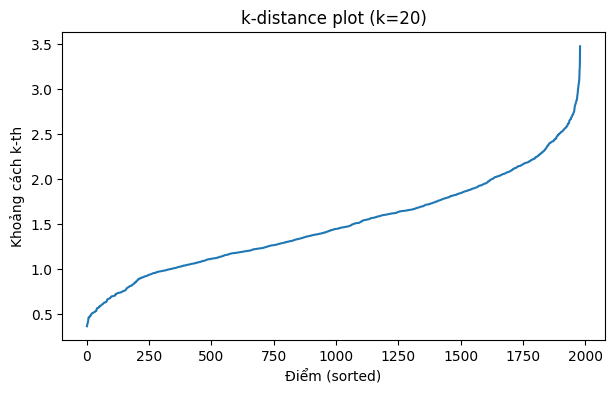

In [556]:
k = max(5, 2*X.shape[1])  # rule of thumb
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
dist, _ = nbrs.kneighbors(X)
kdist = np.sort(dist[:, -1])

plt.figure(figsize=(7,4))
plt.plot(kdist); plt.title(f'k-distance plot (k={k})')
plt.xlabel('Điểm (sorted)'); plt.ylabel('Khoảng cách k-th'); plt.show()


In [557]:
for eps_test in [1.2, 1.5, 1.8, 2.0, 2.3]:
    db = DBSCAN(eps=eps_test, min_samples=10).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise = (labels == -1).mean()
    print(f"eps={eps_test}: cụm={n_clusters}, noise={noise:.2%}")


eps=1.2: cụm=12, noise=32.86%
eps=1.5: cụm=5, noise=14.69%
eps=1.8: cụm=1, noise=5.35%
eps=2.0: cụm=1, noise=2.62%
eps=2.3: cụm=1, noise=0.30%


In [558]:
# DBSCAN với eps = 1.5
db = DBSCAN(eps=1.5, min_samples=10).fit(X)
df['db'] = db.labels_

# K-Means để so sánh
km = KMeans(n_clusters=5, random_state=42).fit(X)
df['km'] = km.labels_

# Chỉ tính Silhouette nếu DBSCAN ra >=2 cụm khác nhau (bỏ noise -1)
mask = df['db'] != -1
n_clusters_db = len(set(df['db'][mask]))

if n_clusters_db > 1:
    print("Silhouette DBSCAN:", silhouette_score(X[mask], df['db'][mask]))
else:
    print("DBSCAN chỉ có 1 cụm hợp lệ → không tính được Silhouette")

print("Silhouette KMeans:", silhouette_score(X, df['km']))


Silhouette DBSCAN: 0.07078658066441573
Silhouette KMeans: 0.17529764603220044


## Hierarchical clustering 

In [559]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as pl

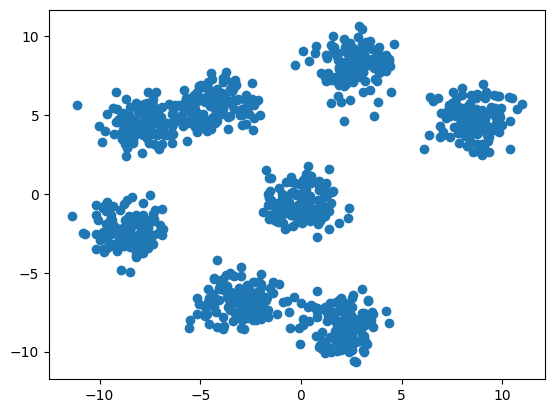

In [560]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
# Generate a random cluster dataset to experiment on. 
# X = coordinate points, y = cluster labels (not needed)
X, y = make_blobs(n_samples=1000, centers=8, n_features=2,
random_state=800)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [561]:
# Generate distance matrix with 'linkage' function
distances = linkage(X, method="centroid", metric="euclidean")
print(distances)

[[5.72000000e+02 7.62000000e+02 7.69412624e-03 2.00000000e+00]
 [3.00000000e+01 1.96000000e+02 8.87881891e-03 2.00000000e+00]
 [5.91000000e+02 8.70000000e+02 1.07476240e-02 2.00000000e+00]
 ...
 [1.98900000e+03 1.99200000e+03 7.81168528e+00 3.75000000e+02]
 [1.99500000e+03 1.99600000e+03 1.02408477e+01 7.50000000e+02]
 [1.99400000e+03 1.99700000e+03 1.20025814e+01 1.00000000e+03]]


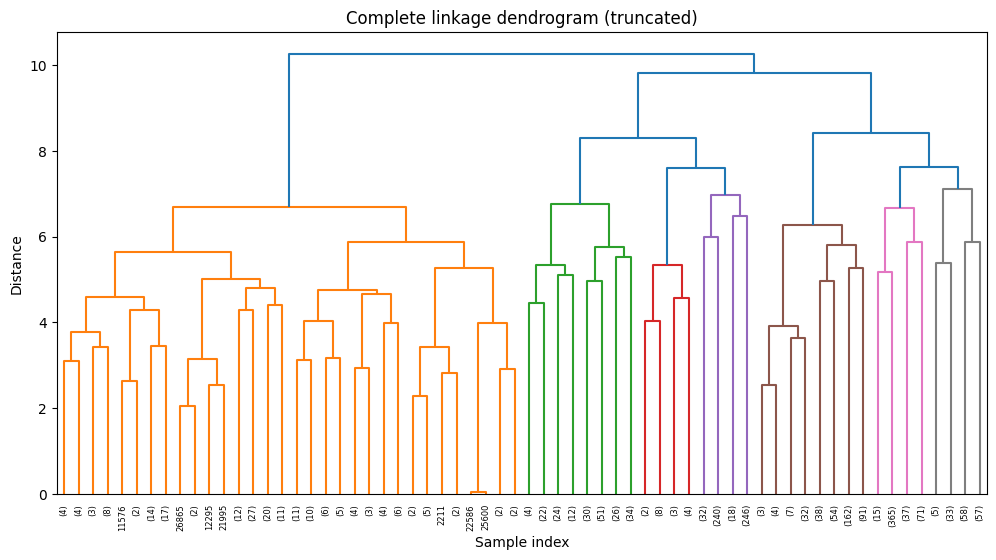

In [562]:
# select numeric columns only (or list the feature column names you want)
numeric_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()
X_hier = vietnam_housing_clean[numeric_cols].dropna()

if X_hier.shape[0] < 2 or X_hier.shape[1] < 1:
    raise ValueError("Not enough numeric rows/columns for hierarchical clustering. Check vietnam_housing_clean.")

# convert to numpy array (float) for linkage
X_vals = X_hier.values.astype(float)

complete_clustering = linkage(X_vals, method="complete", metric="euclidean")
average_clustering  = linkage(X_vals, method="average",  metric="euclidean")
single_clustering   = linkage(X_vals, method="single",   metric="euclidean")

# optional: plot a truncated dendrogram for the complete linkage
plt.figure(figsize=(12, 6))
dendrogram(complete_clustering, truncate_mode='level', p=5, labels=X_hier.index)
plt.title("Complete linkage dendrogram (truncated)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

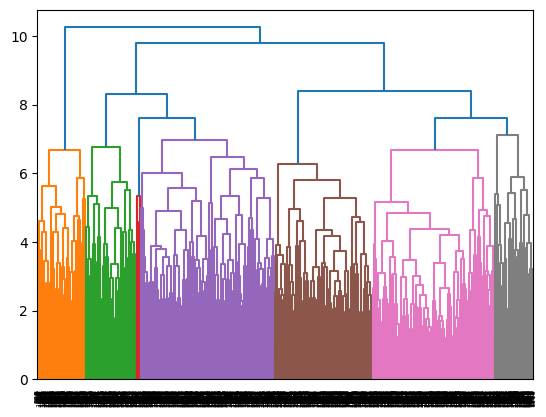

In [563]:
dendrogram(complete_clustering)
plt.show()

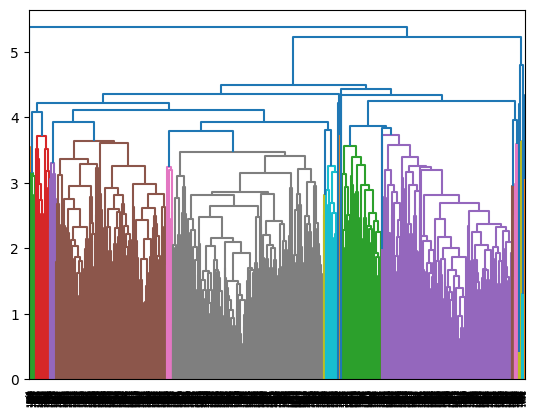

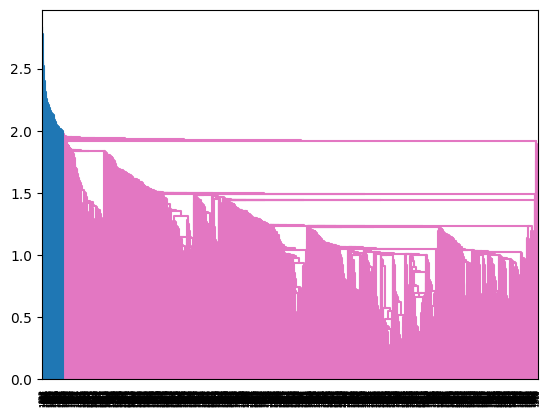

In [564]:
dendrogram(average_clustering)
plt.show()
dendrogram(single_clustering)
plt.show()

best_k=2, silhouette=0.0078


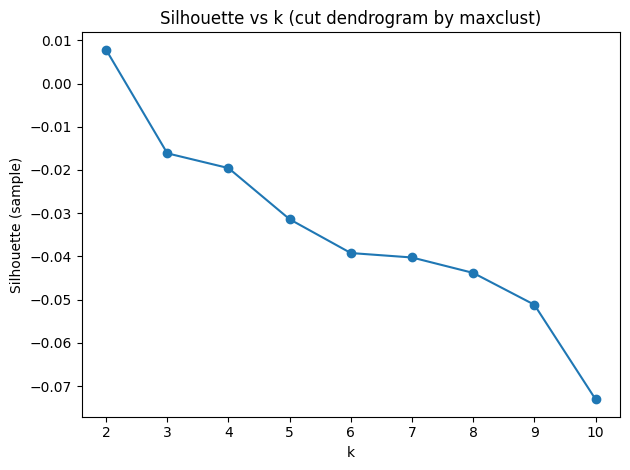

In [567]:
Z = complete_clustering 
X_hier = X 
n = len(X_hier)
idx = np.random.default_rng(42).choice(n, size=min(2000, n), replace=False)
X_s = X_hier[idx]
k_grid = range(2, 11)
sil_scores = [silhouette_score(X_s, fcluster(Z, t=k, criterion="maxclust")[idx]) for k in k_grid]
best_k = list(k_grid)[int(np.nanargmax(sil_scores))]

print(f"best_k={best_k}, silhouette={np.nanmax(sil_scores):.4f}")
plt.plot(list(k_grid), sil_scores, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette (sample)")
plt.title("Silhouette vs k (cut dendrogram by maxclust)")
plt.tight_layout(); plt.show()


In [ ]:
# GÁN NHẪN CỤM CHO TOÀN BỘ DỮ LIỆU VỚI best_k ---
labels = fcluster(Z, t=best_k, criterion="maxclust")  # 1..best_k
# ensure labels is 1D and aligns with X_hier index
labels = np.asarray(labels).ravel()
if labels.shape[0] != X_hier.shape[0]:
    # GÁN NHẪN CỤM CHO TOÀN BỘ DỮ LIỆU VỚI best_k ---
    labels = fcluster(Z, t=best_k, criterion="maxclust")  # 1..best_k
    # ensure labels is 1D and aligns with X_hier index
    labels = np.asarray(labels).ravel()
    if labels.shape[0] != X_hier.shape[0]:
        # Try to recover the original X_hier used to compute Z (if vietnam_housing_clean + numeric_cols exist)
        try:
            X_hier_candidate = vietnam_housing_clean[numeric_cols].dropna()
        except Exception:
            X_hier_candidate = None

        if X_hier_candidate is not None and labels.shape[0] == X_hier_candidate.shape[0]:
            # restore X_hier to the dataframe that matches the linkage matrix
            X_hier = X_hier_candidate
        else:
            n_from_Z = (Z.shape[0] + 1) if hasattr(Z, "shape") else None
            raise ValueError(
                f"labels length ({labels.shape[0]}) does not match X_hier rows ({X_hier.shape[0]}). "
                f"Linkage matrix Z corresponds to {n_from_Z} original observations. "
                f"Ensure you are cutting the same linkage matrix Z that was built from X_hier."
            )

    labels_ser = pd.Series(labels, index=X_hier.index, name="hcluster_label")

    # TÓM TẮT CỤM (median theo đơn vị đang có trong X_hier - là thang đã scale) ---
    summary_rows = []
    for c in sorted(np.unique(labels)):
        mask = (labels_ser.values == c)
        row = {"Cluster": int(c), "Count": int(mask.sum())}
        row.update(pd.DataFrame(X_hier.values[mask], columns=numeric_cols).median().to_dict())
        summary_rows.append(row)
    summary_df = pd.DataFrame(summary_rows).sort_values("Cluster").reset_index(drop=True)
    print("\n=== Cluster medians (trên thang đã chuẩn hoá) ===")
    display(summary_df)
labels_ser = pd.Series(labels, index=X_hier.index, name="hcluster_label")



=== Cluster medians (trên thang đã chuẩn hoá) ===


,Cluster,Count,Area,Frontage,Access_Road,Floors,Bedrooms,Bathrooms,Legal_status,Furniture_state,Price,House_direction_sin,House_direction_cos,Balcony_direction_sin,Balcony_direction_cos
0,1,193,-0.357307,-0.511298,-0.183777,5.0,0.855516,1.59219,0.0,1.0,0.748416,0.0,1.0,0.0,1.0
1,2,1788,-0.110938,-0.246976,-0.183777,3.0,-0.369034,-0.21637,0.0,1.0,-0.235342,0.0,1.0,0.0,1.0


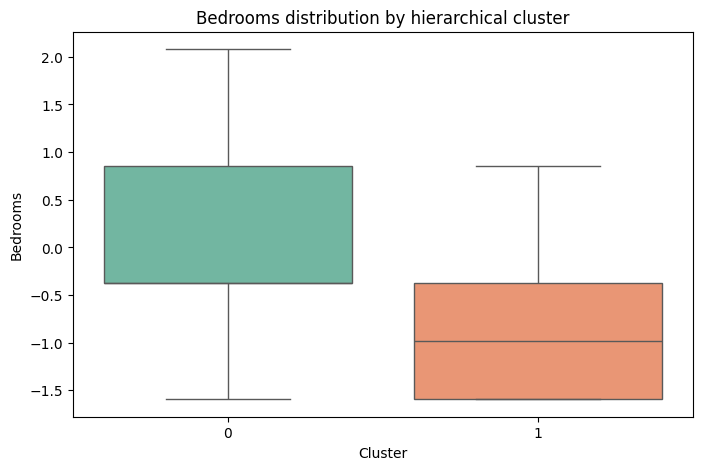

In [ ]:
from scipy.cluster.hierarchy import cut_tree
import seaborn as sns
import matplotlib.pyplot as plt
# Cắt cây dendrogram thành 2 cụm (đổi số nếu muốn)
cluster_labels = cut_tree(average_clustering, n_clusters=2).reshape(-1, )

# Gắn nhãn cụm vào dataframe đang dùng (X_hier hoặc vietnam_housing_scaled)
df_cluster = X_hier.copy()
df_cluster["Cluster"] = cluster_labels

# Chọn biến để xem ý nghĩa (ví dụ 'Price')
target = "Bedrooms"

# Vẽ boxplot để so sánh phân bố biến theo cụm
plt.figure(figsize=(8,5))
sns.boxplot(x="Cluster", y=target, data=df_cluster, palette="Set2")
plt.title(f"{target} distribution by hierarchical cluster")
plt.show()

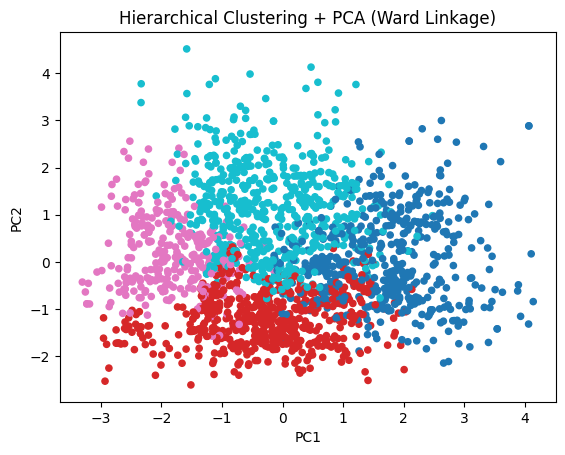

In [570]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt

# B1: Chuẩn hóa trực tiếp
num_cols = ['Area','Frontage','Bedrooms','Bathrooms','Price']
X = vietnam_housing_clean[num_cols].dropna().copy() 
X[num_cols] = StandardScaler().fit_transform(X[num_cols])

# B2: Dùng chính X đã scale để phân cụm (không cần X_scaled riêng)
X_scaled = X[num_cols].values

# B3: Hierarchical Clustering với Ward (phù hợp dữ liệu dạng số)
Z = linkage(X_scaled, method='ward')

# B4: Cắt cụm (chọn 4 hoặc 5 cụm)
labels_hier = fcluster(Z, t=4, criterion='maxclust')
X['hcluster'] = labels_hier

# B5: Giảm chiều bằng PCA để xem cụm
pca = PCA(n_components=2).fit_transform(X_scaled)
plt.scatter(pca[:,0], pca[:,1], c=labels_hier, cmap='tab10', s=20)
plt.title("Hierarchical Clustering + PCA (Ward Linkage)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [ ]:
import numpy as np

print("Số cụm thật sự:", len(np.unique(labels)))
print("Phân bố nhãn:", np.unique(labels, return_counts=True))


Số cụm thật sự: 2
Phân bố nhãn: (array([1, 2], dtype=int32), array([ 193, 1788]))


In [571]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
# 1. Chuẩn hóa
X = vietnam_housing[num_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)
# 2. Linkage
Z = linkage(X_scaled, method='ward')
# 3. Cắt cụm (ví dụ 4 cụm)
labels = fcluster(Z, t=2, criterion='maxclust')
# 4. Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print("✅ Silhouette Score:", sil_score)


✅ Silhouette Score: 0.20262911245627818


In [ ]:
import joblib
joblib.dump(km, "kmeans_model.joblib")
# load: km = joblib.load("kmeans_model.joblib")

['kmeans_model.joblib']